This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [160]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Local imports
import sys
sys.path.append('../')
import stlstuff as sls
import imagestuff as ims
import facetbrightnessstuff9 as fbs
import f90nml
import gradstuff as gds

In [161]:
%matplotlib notebook

In [162]:
# Define the variance in the observations (BS units^2)
#noiseamp = 5.0
noiseamp = .1**2
noisestd = noiseamp**.5
print('Se^.5 is', noisestd)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0
print('Std deviation in a priori is', apriorivar0**.5)

Se^.5 is 0.1
Std deviation in a priori is 15.0


In [163]:
# Read and unpack the calibration data
Calibration=f90nml.read('Calibration.nml') #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

In [164]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [165]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes

In [166]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
fbs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [167]:
# Create a height surface
Truenx = 50; Trueny = 51
dx = dy = 0.5
Truesolution = np.zeros((Trueny,Truenx))
slopey = 0.0
slopex = 0.05
for ix in range(Truenx):
    for iy in range(Trueny):
        Truesolution[iy,ix] += iy*slopey*dy
for ix in range(Truenx):
    for iy in range(Trueny):
        Truesolution[iy,ix] += ix*slopex*dx
#print(np.shape(Truesolution))

<IPython.core.display.Javascript object>


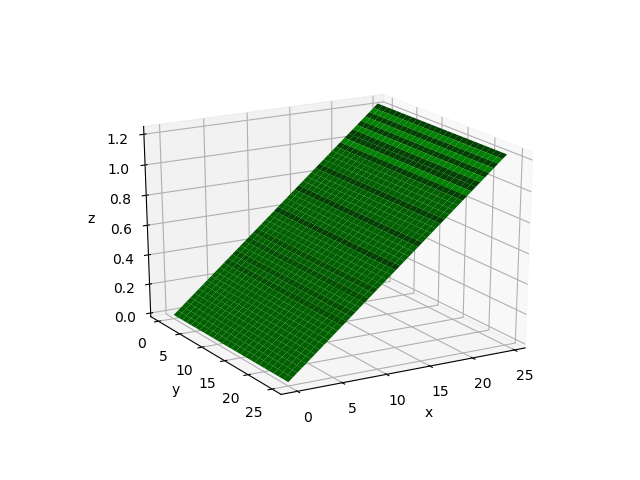

In [168]:
# Display this surface
ymax = dy*(Trueny-1)
xmax = dx*(Truenx-1)
surf_ytot = np.linspace(0,ymax,Trueny); #print(surf_ytot[1]-surf_ytot[0]); 
surf_xtot = np.linspace(0,xmax,Truenx); #print(surf_xtot[1]-surf_xtot[0]); 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, Truesolution, color='g')
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=-120,elev=22)

In [169]:
# Create "observed" backscatter intensities from the forward model

# Get gradients of the true solution
surf_dzgrid_dy_retrieved = np.diff(Truesolution,axis=0)/dy
surf_dzgrid_dx_retrieved = -np.diff(Truesolution,axis=1)/dx

# Generate "observed" backscatter intensities
bigKx = np.matrix(np.empty((4,0)), copy=False)
bigKy = np.matrix(np.empty((4,0)), copy=False)
bigc_last = np.matrix(np.empty((4,0)), copy=False)
for iy in range(Trueny-1):
    for ix in range(Truenx-1):
        dzdx = surf_dzgrid_dx_retrieved[iy,ix]; #print('dzdx =', dzdx)
        dzdy = surf_dzgrid_dy_retrieved[iy,ix]; #print('dzdy =', dzdy)
        nxy_last = np.vstack((dzdx,dzdy))
        K_i, c_last = fbs.getK(nxy_last,
        Arule, Brule, Crule, Drule,
        KAxrule, KAyrule,
        KBxrule, KByrule,
        KCxrule, KCyrule,
        KDxrule, KDyrule)
        bigKx = np.hstack((bigKx,K_i[:,0]))
        bigKy = np.hstack((bigKy,K_i[:,1]))
        bigc_last = np.hstack((bigc_last,c_last))
cA_orig = np.reshape(bigc_last[0],(Trueny-1,Truenx-1))
cB_orig = np.reshape(bigc_last[1],(Trueny-1,Truenx-1))
cC_orig = np.reshape(bigc_last[2],(Trueny-1,Truenx-1))
cD_orig = np.reshape(bigc_last[3],(Trueny-1,Truenx-1))
ny,nx = cA_orig.shape; 
print(ny,nx)

50 49


In [170]:
# Add some noise to the observed signals
actualnoise = 2
cA = cA_orig + np.random.randn(ny,nx)*noisestd*actualnoise
cB = cB_orig + np.random.randn(ny,nx)*noisestd*actualnoise
cC = cC_orig + np.random.randn(ny,nx)*noisestd*actualnoise
cD = cD_orig + np.random.randn(ny,nx)*noisestd*actualnoise
print(np.std(cA))
print(np.max(cA))
print(np.min(cA))

0.2013902453185237
68.67269612473704
67.21331139035138


<IPython.core.display.Javascript object>


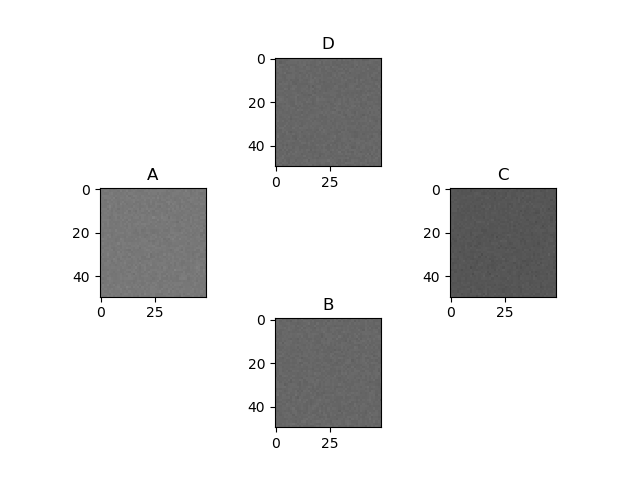

Text(0.5,1,'D')

In [171]:
plt.figure()
vmin = 60; vmax = 80
plt.subplot(334); plt.imshow(np.asarray(cA), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('A')
plt.subplot(338); plt.imshow(np.asarray(cB), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('B')
plt.subplot(336); plt.imshow(np.asarray(cC), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('C')
plt.subplot(332); plt.imshow(np.asarray(cD), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('D')

In [172]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [173]:
# Generic retrieval parameters
maxiter = 4
tolerance = 10

In [174]:
# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

In [175]:
# Retrieve 

# Construct gradients
Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
Ny = Ny_unscaled/dy
Nx = -Nx_unscaled/dx #fixing x inversion

# Number of observations
nobs = (nx-1)*(ny-1)*4; #print(nobs)

# Number of desired points (heights)
nzpts = ny*nx-1; print(nzpts)

# Extract the a priori variance
vartemp = apriorivar[0:ny,0:nx]
vartemp_long = np.reshape(vartemp,nzpts+1,0)
Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)

# Extract the starting z
settemp = copy.copy(solution)
settemp_long = np.reshape(settemp,nzpts+1,0)
settemp_longminus1 = settemp_long[:-1]
z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
z_start = z_start*0.0; #print "aprioriset", shape(z_start)

# Construct the variance in observation + model
Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

# Do the retrieval
print('')
z_retrieved = fbs.retrievesegment(\
0,0,nx-1,ny-1,cA,cB,cC,cD,\
Sa,Se,z_start,maxiter,tolerance,\
Nx,Ny,\
Arule, Brule, Crule, Drule,\
KAxrule, KAyrule, \
KBxrule, KByrule, \
KCxrule, KCyrule, \
KDxrule, KDyrule)

solution = copy.copy(z_retrieved)

2449

Observed intensities (detector B):
mean, max, min = 66.60053220791086 67.22927682265274 65.97880120892214
<diff>, std(diff), di2 = 0.0046584625329021915 0.9314005389385708 788751.4347028728
<diff>, std(diff), di2 = -0.004170737057511539 0.17066917353934796 0.4757245614605419


In [176]:
# Re-level to match the true solution as closely as possible
shift = np.mean(Truesolution[1:,1:]-solution); #print(shift)
solution += shift

<IPython.core.display.Javascript object>


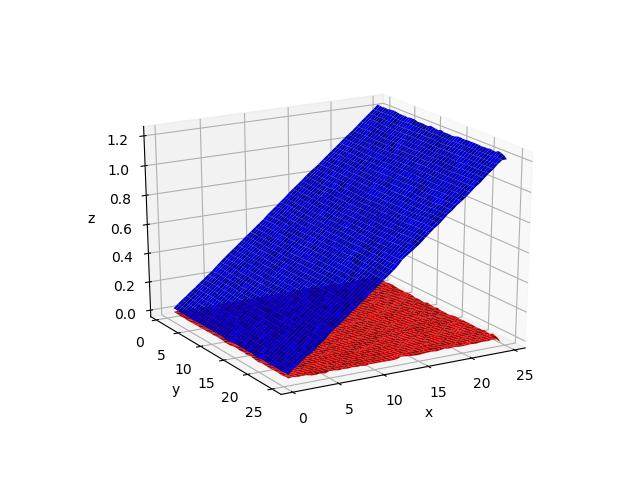

<IPython.core.display.Javascript object>


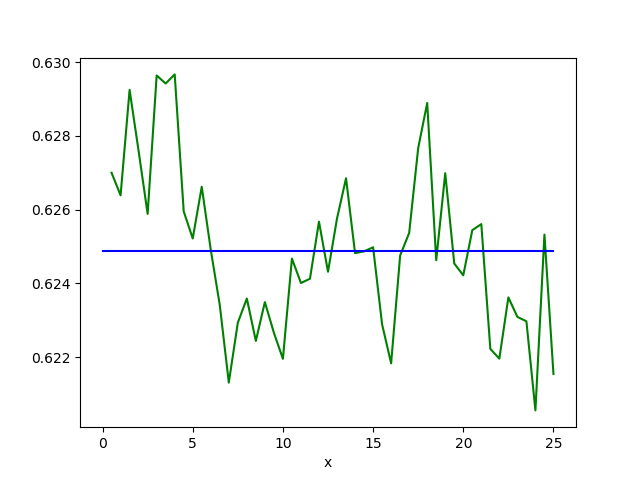

0.0025112231473524566


In [187]:
# Show the reconstructed surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot[1:,1:], surf_ygridtot[1:,1:], solution, color='b')
ax.plot_surface(surf_xgridtot[1:,1:], surf_ygridtot[1:,1:], solution-Truesolution[1:,1:], color='r')
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=-120,elev=22)


plt.figure()
midpt = int(nx/2)
shift = np.mean(solution[:,midpt])-np.mean(Truesolution[:,midpt])
plt.plot(surf_ytot[1:],np.array(solution[:,midpt]), color='g')
plt.plot(surf_ytot,Truesolution[:,midpt]+shift, color='b')
plt.xlabel('x')

error = np.std(solution-Truesolution[1:,1:]); print(error)

In [178]:
# Save this data

#save an image
fig.savefig('benchmark.jpg')

Compressedfilename = 'benchmarkretrieved.npz'
print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot='2018', \
                    imageroot='2018', \
                    nx1list=[0], \
                    nx2list=[nx-1], \
                    ny1list=[0], \
                    ny2list=[ny-1], \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving benchmarkretrieved.npz
